In [4]:
import statsmodels
import numpy as np
import sys
sys.path.append('../plots/' )
from model_comparison import return_model_comparison_metrics
from load_human_behavior import load_behavior, load_percondition_metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [5]:
NUM_TASKS = 20
NUM_TRIALS = 5

In [8]:
rule='add'

In [19]:
actions, _, _, best = np.load(f'/notebooks/modelfits/simulated_data_preds/mean_tracker_compositional/stats_mean_tracker_compositional_simulated_compositional_{rule}_composed.npy')
mtc_probs = (actions==best).mean(1).mean(1).mean(1)[:, 2, 0]

In [20]:
def make_dataframe(data, EXPERIMENT):
    
    NUM_SUBTASKS = 3 if EXPERIMENT == 'compositional' else 1
    SUBTASK = 2 if EXPERIMENT == 'compositional' else 0
    comp_data = data[(data['experiment']==EXPERIMENT)]
    subjs = comp_data.index 
    subj_ids = np.repeat(data[data.experiment == EXPERIMENT].index, NUM_TASKS*NUM_TRIALS)
    actions = np.stack([data.iloc[idx].actions[SUBTASK::NUM_SUBTASKS].reshape(-1) for idx in list(subjs)]).reshape(-1)
    regrets = np.stack([data.iloc[idx].regrets[SUBTASK::NUM_SUBTASKS].reshape(-1) for idx in list(subjs)]).reshape(-1)
    lin_regrets = np.stack([data.iloc[idx].regrets[0::NUM_SUBTASKS].reshape(-1) for idx in list(subjs)]).reshape(-1)
    if EXPERIMENT == 'compositional':
        lin_regrets = np.stack([data.iloc[idx].regrets[0::NUM_SUBTASKS].sum(1).repeat(NUM_TRIALS) for idx in list(subjs)]).reshape(-1)
        per_regrets = np.stack([data.iloc[idx].regrets[1::NUM_SUBTASKS].sum(1).repeat(NUM_TRIALS) for idx in list(subjs)]).reshape(-1)
        linper_regrets =  np.stack([data.iloc[idx].regrets[2::NUM_SUBTASKS].sum(1).repeat(NUM_TRIALS) for idx in list(subjs)]).reshape(-1)
    rewards = np.stack([data.iloc[idx].rewards[SUBTASK::NUM_SUBTASKS].reshape(-1) for idx in list(subjs)]).reshape(-1)
    trials =  np.arange(NUM_TRIALS).reshape(1,-1).repeat(NUM_TASKS*len(subjs), 0).reshape(-1)
    trials = trials - trials.mean()
    opt_arms = np.stack([data.iloc[idx].best_actions[SUBTASK::NUM_SUBTASKS] for idx in list(subjs)]).reshape(-1)
    conditions = np.stack([.5 if data.iloc[idx].experiment == 'compositional' else -.5 for idx in list(subjs)]).reshape(-1).repeat(NUM_TASKS*NUM_TRIALS)
    
    datadict = {'subj_ids': subj_ids, 'trials': trials, 'interaction': trials*conditions, 'conditions': conditions, 'regrets': regrets, 'linregrets': lin_regrets, 'perregrets': per_regrets,  'linperregrets': linper_regrets,  'lin_interaction': lin_regrets*trials, 'per_interaction': per_regrets*trials, 'linper_interaction': per_regrets*lin_regrets*trials} if EXPERIMENT == 'compositional' else {'subj_ids': subj_ids, 'trials': trials, 'interaction': trials*conditions, 'conditions': conditions, 'regrets': regrets}
    return pd.DataFrame(datadict)

## load data

In [25]:
rule = 'changepoint'
data = load_behavior(rule)

In [26]:
optimal_actions_dict, pooled_rewards_dict, \
pooled_regrets_dict, pooled_times_dict, pooled_rewards_tasks_dict, \
pooled_regrets_tasks_dict, pooled_times_tasks_dict, n_subjs = load_percondition_metrics(rule)

In [27]:
data_c = make_dataframe(data, 'compositional')
data_nc = make_dataframe(data, 'noncompositional')
pooled_data = pd.concat((data_c, data_nc))

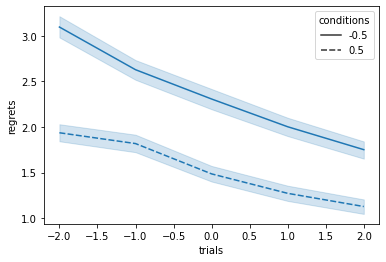

In [28]:
sns.lineplot(x="trials", y="regrets", style="conditions", data=pooled_data)
plt.show()

## t-test compring regrets on the first trial of curriculum condition with optimal policy


In [29]:
from scipy.stats import ttest_ind

In [30]:
people_regrets_first_trial_compositional = pooled_data['regrets'][(pooled_data['trials']==-2)*(pooled_data['conditions']==0.5)].values
optimal_regrets_first_trial_compositional = np.zeros_like(people_regrets_first_trial_compositional)
rng = np.random.default_rng()
# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(people_regrets_first_trial_compositional, optimal_regrets_first_trial_compositional, alternative='two-sided', permutations=1000, random_state=rng)
print(people_regrets_first_trial_compositional.mean(), optimal_regrets_first_trial_compositional.mean(), t_stat, p_val)

1.9372095963823686 0.0 38.2473512956393 0.0


## t-test comparing regrets on the first trial

In [31]:
from scipy.stats import ttest_ind

TRIAL = -2
CONDITION1 = 0.5 
CONDITION2 = -0.5 
group1 = pooled_data['regrets'][(pooled_data['trials']==TRIAL)*(pooled_data['conditions']==CONDITION1)].values
group2 = pooled_data['regrets'][(pooled_data['trials']==TRIAL)*(pooled_data['conditions']==CONDITION2)].values

# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(group1, group2)
print(group1.mean(), group2.mean(), t_stat, p_val)

1.9372095963823686 3.0961608949628676 -15.105262892304685 3.017970387948785e-50


## t-test comparing regrets on first trial of noncompositional vs last trial of the composoitional

In [32]:
from scipy.stats import ttest_ind

TRIAL1 = 2
TRIAL2 = -2
CONDITION1 = -0.5 
CONDITION2 = 0.5 
group1 = pooled_data['regrets'][(pooled_data['trials']==TRIAL1)*(pooled_data['conditions']==CONDITION1)].values
group2 = pooled_data['regrets'][(pooled_data['trials']==TRIAL2)*(pooled_data['conditions']==CONDITION2)].values

# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(group1, group2)
print(group1.mean(), group2.mean(), t_stat, p_val)

1.751975741073964 1.9372095963823686 -2.60474084115732 0.009226649418787423


## t-test probs of optimal choice on first trial

In [33]:
data_comp = data[(data['experiment']=='compositional')]
data_noncomp = data[(data['experiment']=='noncompositional')]
prob_opt_noncompositonal_first = np.stack([data_noncomp.iloc[subj].optimal_actions[:, 0].mean() for subj in range(n_subjs['noncompositional'])])
prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0].mean() for subj in range(n_subjs['compositional'])])

In [34]:
group1 = prob_opt_noncompositonal_first
group2 = prob_opt_compositional_first

# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(group1, group2)
print(group1.mean(), group1.std()/np.sqrt(len(group1)-1), group2.mean(), group2.std()/np.sqrt(len(group2)-1), t_stat, p_val)

0.16813725490196077 0.007997682629025234 0.3371559633027522 0.01580875109975486 -9.346964932148962 1.4159796602016358e-17


## t-tests between fitted poster regresion coefficients for regrets

In [35]:
import pickle
from scipy.stats import ttest_ind
rng = np.random.default_rng()
with open(f'../modelfits/analysis_regrets/traces_{rule}.pkl', 'rb') as fp:
    trace_first, list_of_errors = pickle.load(fp)
for error in list_of_errors:
    lin = trace_first[error].posterior.w_lin.values.reshape(-1) 
    per = trace_first[error].posterior.w_per.values.reshape(-1) 
    t_stat, p_val = ttest_ind(lin, per, permutations=1000, random_state=rng, alternative='two-sided')
    print(error, lin.mean(), lin.std()/np.sqrt(len(lin)-1), per.mean(), per.std()/np.sqrt(len(per)-1), t_stat, p_val)

optimal -0.042261004691545076 7.518334757833702e-05 -0.046412650682539774 5.037790040261795e-05 45.87392914144813 0.0
corner_non_optimal -0.0606851852409295 7.662927565391976e-05 -0.03050848261508484 5.004231055962401e-05 -329.72070730506977 0.0
phasic_non_optimal -0.025895727444285525 7.066226351048486e-05 -0.020289969592711052 4.6723088732594134e-05 -66.17393966053896 0.0
neither 0.11372631675081867 9.796539075451798e-05 0.07471662454894867 6.36792009641809e-05 333.86452359780526 0.0


## t-tests between fitted poster regresion coefficients for model regrets

In [9]:
import pickle
from scipy.stats import ttest_ind
import numpy as np 

rng = np.random.default_rng()
with open(f'../modelfits/analysis_regrets/traces_{rule}_rl3.pkl', 'rb') as fp:
    trace_first, list_of_errors = pickle.load(fp)
for error in list_of_errors:
    lin = trace_first[error].posterior.w_lin.values.reshape(-1) 
    per = trace_first[error].posterior.w_per.values.reshape(-1) 
    t_stat, p_val = ttest_ind(lin, per, permutations=1000, random_state=rng, alternative='two-sided')
    print(error, lin.mean(), lin.std()/np.sqrt(len(lin)-1), per.mean(), per.std()/np.sqrt(len(per)-1), t_stat, p_val)

optimal -0.28297567562383763 0.00018989075123746288 -0.16034837951673594 0.0001512966277775982 -505.0662121469511 0.0
corner_non_optimal -0.3174292523681016 0.00022682627574045628 -0.3628807671465295 0.00021123361161017726 146.6408342936396 0.0
phasic_non_optimal -0.2482791514848122 0.00019720895709069927 -0.2945940515801995 0.00017950213578811063 173.67931420700154 0.0
neither 0.7048298343059726 0.00040800987429745754 0.6280295066016681 0.00036068063424325833 141.02785466031565 0.0


## t-test between fitted model simulations and people

In [44]:
import torch

fit_subtasks='composed'
n_participants = 92 if rule=='add' else 109
changepoint = False if rule == 'add' else True
full = True if fit_subtasks=='all' else False
means, std_errors = [], []

# people probs
data_comp = data[(data['experiment']=='compositional')]
data_noncomp = data[(data['experiment']=='noncompositional')]
prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0].mean() for subj in range(n_subjs['compositional'])])
means.append(prob_opt_compositional_first.mean())
std_errors.append(prob_opt_compositional_first.std()/np.sqrt(n_subjs['compositional']))

# RL3
actions, _, _, _, true_best_action = torch.load(f'/notebooks/scratch/RL3NeurIPS/data/RL3Fits/fitted_simulations/all_stats_changepoint={changepoint}_full={full}_entropyTruejagadish2022curriculum-v0_pertrial0.pth')
sim_rl3_probs = (actions==true_best_action).to(torch.float)[:, :20]
means.append(sim_rl3_probs.mean(1).mean(0)[10])
std_errors.append(sim_rl3_probs.mean(1).std(0)[10]/np.sqrt(sim_rl3_probs.shape[0]))

TASK_ID = 2
if rule == 'changepoint':
    'test'
    actions, _, _, best = np.load(f'/notebooks/modelfits/simulated_data_preds/mean_tracker_compositional/stats_mean_tracker_compositional_simulated_compositional_{rule}_composed.npy')
    mtc_probs = (actions==best).mean(1).mean(1).mean(1)[:, TASK_ID, 0]
    means.append(mtc_probs.mean(0))
    std_errors.append(mtc_probs.std(0)/np.sqrt(n_participants))
else:
    actions, _, _, best = np.load(f'/notebooks/modelfits/simulated_data_preds/mean_tracker_compositional/stats_mean_tracker_compositional_simulated_compositional_{rule}_composed.npy')
    mtc_probs = (actions==best).squeeze().mean(1).mean(1)[:, TASK_ID, 0]
    means.append(mtc_probs.mean(0))
    std_errors.append(mtc_probs.std(0)/np.sqrt(n_participants))

### people and RL3

In [37]:
from scipy.stats import ttest_ind
rng = np.random.default_rng()

group1 = prob_opt_compositional_first
group2 = sim_rl3_probs[:, :, 10].mean(1).reshape(-1).numpy()

# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(group1, group2, permutations=1000, random_state=rng)#, alternative='two-sided')
print(group1.mean(), group1.std()/np.sqrt(len(group1)-1), group2.mean(), group2.std()/np.sqrt(len(group2)-1), t_stat, p_val)

0.3371559633027522 0.01580875109975486 0.29220182 0.01316687457017781 2.1850140358506973 0.033


### people and MTC

In [49]:
from scipy.stats import ttest_ind
rng = np.random.default_rng()

group1 = prob_opt_compositional_first
group2 = mtc_probs = (actions==best).mean(1).mean(1).mean(1)[:, TASK_ID, 0]

# calculate the t-statistic and p-value
t_stat, p_val = ttest_ind(group1, group2, permutations=1000, random_state=rng)#, alternative='two-sided')
print(group1.mean(), group1.std()/np.sqrt(len(group1)-1), group2.mean(), group2.std()/np.sqrt(len(group2)-1), t_stat, p_val)

0.3371559633027522 0.01580875109975486 0.2861811926605505 0.0068882763197996915 2.9560405199838407 0.004


In [39]:
t_stat, p_val

(array([5.61270513, 4.7946584 , 4.01431059, 2.98412726, 1.00044593]),
 array([0.   , 0.   , 0.   , 0.002, 0.311]))

## is there an effect of trials and condition?

In [16]:
md = smf.mixedlm("regrets ~ trials + interaction + conditions", data=pooled_data, groups=pooled_data["subj_ids"])#, re_formula="~trials")
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regrets    
No. Observations: 21100   Method:             REML       
No. Groups:       211     Scale:              4.7961     
Min. group size:  100     Log-Likelihood:     -46718.9750
Max. group size:  100     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      1.943    0.045  43.135 0.000  1.855  2.031
trials        -0.274    0.011 -25.671 0.000 -0.295 -0.253
interaction    0.115    0.021   5.396 0.000  0.073  0.157
conditions    -0.829    0.090  -9.196 0.000 -1.005 -0.652
Group Var      0.380    0.019                            



## how does regret change with trial number: compositional vs noncompositional?

In [17]:
## compositional
md = smf.mixedlm("regrets ~ trials", data=data_c, groups=data_c["subj_ids"]) #, re_formula="~trials")
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regrets    
No. Observations: 10900   Method:             REML       
No. Groups:       109     Scale:              3.9275     
Min. group size:  100     Log-Likelihood:     -23073.8327
Max. group size:  100     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      1.529    0.074  20.772 0.000  1.385  1.673
trials        -0.216    0.013 -16.112 0.000 -0.243 -0.190
Group Var      0.551    0.041                            



In [18]:
## noncompositional
md = smf.mixedlm("regrets ~ trials", data=data_nc, groups=data_nc["subj_ids"])#, re_formula="~trials")
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regrets    
No. Observations: 10200   Method:             REML       
No. Groups:       102     Scale:              5.7243     
Min. group size:  100     Log-Likelihood:     -23451.4542
Max. group size:  100     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      2.357    0.050  47.258 0.000  2.260  2.455
trials        -0.331    0.017 -19.783 0.000 -0.364 -0.299
Group Var      0.197    0.015                            



## how well does cum. linear and periodic regrets explain composite regrets?

In [23]:
md = smf.mixedlm("linperregrets ~ linregrets + perregrets", data=data_c, groups=data_c["subj_ids"], re_formula="~linregrets + perregrets")
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    linperregrets
No. Observations:     9200       Method:                REML         
No. Groups:           92         Scale:                 45.2267      
Min. group size:      100        Log-Likelihood:        -30957.8524  
Max. group size:      100        Converged:             Yes          
Mean group size:      100.0                                          
---------------------------------------------------------------------
                            Coef.  Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                    5.923    0.784 7.553 0.000  4.386  7.460
linregrets                   0.181    0.068 2.663 0.008  0.048  0.314
perregrets                   0.241    0.046 5.257 0.000  0.151  0.331
Group Var                   52.124    1.244                          
Group x linregrets Cov      -3.009  

## how well does cum. linear and periodic regrets explain composite regrets as a function of trial?

In [86]:
md = smf.mixedlm("regrets ~ linregrets + perregrets + lin_interaction + per_interaction", data=data_c, groups=data_c["subj_ids"], re_formula="~linregrets + perregrets")
mdf = md.fit()
print(mdf.summary())

/home/ajagadish/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ajagadish/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/ajagadish/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     regrets    
No. Observations:      9200        Method:                 REML       
No. Groups:            92          Scale:                  4.9203     
Min. group size:       100         Log-Likelihood:         -20935.2723
Max. group size:       100         Converged:              Yes        
Mean group size:       100.0                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.202    0.110 10.904 0.000  0.986  1.418
linregrets                   0.034    0.052  0.650 0.516 -0.068  0.135
perregrets                   0.044    0.052  0.851 0.395 -0.057  0.146
lin_interaction             -0.006    0.003 -1.779 0.075 -0.012  0.001
per_interaction        

## probability of optimal chioce on base tasks -> probability of optimal choice on the first trial 

In [3]:
rule = 'add'
data = load_behavior(rule)

In [4]:
data_comp = data[(data['experiment']=='compositional')]
data_noncomp = data[(data['experiment']=='noncompositional')]

In [5]:
n_subjs = {}
n_subjs['compositional'] = len(data_comp)
n_subjs['noncompositional'] = len(data_noncomp)

In [6]:
criterion_optimal = 0.6
prob_opt_noncompositonal = np.stack([data_noncomp.iloc[subj].optimal_actions.mean(1) for subj in range(n_subjs['noncompositional'])])
prob_opt_compositional = np.stack([data_comp.iloc[subj].optimal_actions[2::3].mean(1) for subj in range(n_subjs['compositional'])])
prob_opt_noncompositonal_first = np.stack([data_noncomp.iloc[subj].optimal_actions[:, 0].mean() for subj in range(n_subjs['noncompositional'])])
prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0].mean() for subj in range(n_subjs['compositional'])])

In [7]:
prob_opt_compositional_linear_first = np.stack([data_comp.iloc[subj].optimal_actions[0::3, :].mean() for subj in range(n_subjs['compositional'])])
prob_opt_compositional_periodic_first = np.stack([data_comp.iloc[subj].optimal_actions[1::3, :].mean() for subj in range(n_subjs['compositional'])])

In [11]:
def return_probabilities_dataframe(data, EXPERIMENT):
    
    data_comp = data[(data['experiment']==EXPERIMENT)]
    subj_ids = data_comp.index
    prob_opt_compositional_linear = np.stack([data_comp.iloc[subj].optimal_actions[0::3, :].mean() for subj in range(n_subjs['compositional'])])
    prob_opt_compositional_periodic = np.stack([data_comp.iloc[subj].optimal_actions[1::3, :].mean() for subj in range(n_subjs['compositional'])])
    #prob_opt_compositional = np.stack([data_comp.iloc[subj].optimal_actions[2::3].mean(1) for subj in range(n_subjs['compositional'])])
    prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0].mean() for subj in range(n_subjs['compositional'])])
    
    datadict = {'subj_ids': subj_ids, 'p_lin': prob_opt_compositional_linear, 'p_per': prob_opt_compositional_periodic, 'p_linper':prob_opt_compositional_first, 'p_lin_and_per': prob_opt_compositional_periodic*prob_opt_compositional_first}
    return pd.DataFrame(datadict)

In [12]:
probs = return_probabilities_dataframe(data,'compositional')

In [13]:
probs

,subj_ids,p_lin,p_per,p_linper,p_lin_and_per
0,0,0.39,0.24,0.25,0.0600
1,1,0.50,0.23,0.15,0.0345
2,2,0.46,0.25,0.60,0.1500
3,3,0.60,0.22,0.35,0.0770
4,12,0.47,0.30,0.45,0.1350
...,...,...,...,...,...
87,270,0.18,0.18,0.50,0.0900
88,280,0.65,0.21,0.25,0.0525
89,281,0.42,0.25,0.20,0.0500
90,283,0.50,0.20,0.35,0.0700


In [15]:
probs.head()

,subj_ids,p_lin,p_per,p_linper,p_lin_and_per
0,0,0.39,0.24,0.25,0.0600
1,1,0.50,0.23,0.15,0.0345
2,2,0.46,0.25,0.60,0.1500
3,3,0.60,0.22,0.35,0.0770
4,12,0.47,0.30,0.45,0.1350


In [37]:
md = smf.mixedlm("p_linper ~ p_lin + p_per ", data=probs, groups=probs["subj_ids"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: p_linper
No. Observations: 92      Method:             REML    
No. Groups:       92      Scale:              0.0154  
Min. group size:  1       Log-Likelihood:     26.2700 
Max. group size:  1       Converged:          Yes     
Mean group size:  1.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.110    0.071 1.547 0.122 -0.029  0.249
p_lin         0.491    0.073 6.727 0.000  0.348  0.634
p_per         0.333    0.161 2.067 0.039  0.017  0.649
Group Var     0.015                                   



/usr/local/lib/python3.8/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [14]:
md = smf.mixedlm("p_linper ~ p_lin + p_per + p_lin_and_per ", data=probs, groups=probs["subj_ids"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  p_linper
No. Observations:  92       Method:              REML    
No. Groups:        92       Scale:               0.0011  
Min. group size:   1        Log-Likelihood:      141.0769
Max. group size:   1        Converged:           Yes     
Mean group size:   1.0                                   
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.349    0.022  15.668 0.000  0.306  0.393
p_lin          0.042    0.032   1.299 0.194 -0.021  0.106
p_per         -1.301    0.095 -13.716 0.000 -1.487 -1.115
p_lin_and_per  3.480    0.105  33.299 0.000  3.275  3.685
Group Var      0.001                                     



/usr/local/lib/python3.8/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## probit regression from total rewards in the subtasks to p(opt_1) in composed task

In [119]:
rule = 'add'
data = load_behavior(rule)

In [120]:
data_comp = data[(data['experiment']=='compositional')]
data_noncomp = data[(data['experiment']=='noncompositional')]

In [121]:
n_subjs = {}
n_subjs['compositional'] = len(data_comp)
n_subjs['noncompositional'] = len(data_noncomp)

In [122]:
def z_transform(x):
    return (x-x.mean())/x.std()

In [123]:
def return_prob_regrets_dataframe(data, EXPERIMENT):
    
    data_comp = data[(data['experiment']==EXPERIMENT)]
    subj_ids = data_comp.index
    subj_ids = np.repeat(subj_ids, NUM_TASKS)
    lin_regrets = np.stack([data_comp.iloc[idx].regrets[0::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    per_regrets = np.stack([data_comp.iloc[idx].regrets[1::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0] for subj in range(n_subjs['compositional'])]).reshape(-1)
    
    regrets = {'regrets_lin': z_transform(lin_regrets), 'regrets_per': z_transform(per_regrets)}#, 'regrets_linper': z_transform(lin_regrets*per_regrets)}
    probabilities = {'p_linper': prob_opt_compositional_first}
    return pd.DataFrame(regrets), pd.DataFrame(probabilities)

In [124]:
regrets, probabilities = return_prob_regrets_dataframe(data, 'compositional')
regrets = sm.add_constant(regrets, prepend=False)

In [125]:
probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

Optimization terminated successfully.
         Current function value: 0.675266
         Iterations 4
Parameters:  regrets_lin   -0.085593
regrets_per   -0.161677
const          0.145438
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:               p_linper
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0332      0.011     -2.895      0.004      -0.056      -0.011
regrets_per    -0.0627      0.011     -5.497      0.000      -0.085      -0.040


In [126]:
probit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               p_linper   No. Observations:                 1840
Model:                         Probit   Df Residuals:                     1837
Method:                           MLE   Df Model:                            2
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                 0.01654
Time:                        21:09:34   Log-Likelihood:                -1242.5
converged:                       True   LL-Null:                       -1263.4
Covariance Type:            nonrobust   LLR p-value:                 8.459e-10
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0856      0.030     -2.874      0.004      -0.144      -0.027
regrets_per    -0.1617      0.030     -5.363      0.000      -0.221      -0.103
const           0.1454      0.030      4.926      0.000       0.088       0.203
===============================================================================
"""

#### mean regrets

In [127]:
def return_prob_regrets_dataframe_mean(data, EXPERIMENT):
    
    data_comp = data[(data['experiment']==EXPERIMENT)]
    subj_ids = data_comp.index
    subj_ids = np.repeat(subj_ids, NUM_TASKS)
    lin_regrets = np.stack([data_comp.iloc[idx].regrets[0::3].mean(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    per_regrets = np.stack([data_comp.iloc[idx].regrets[1::3].mean(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    prob_opt_compositional_first = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0] for subj in range(n_subjs['compositional'])]).reshape(-1)
    
    regrets = {'regrets_lin': z_transform(lin_regrets), 'regrets_per': z_transform(per_regrets), 'regrets_linper': z_transform(lin_regrets*per_regrets)}
    probabilities = {'p_linper': prob_opt_compositional_first}
    return pd.DataFrame(regrets), pd.DataFrame(probabilities)

In [128]:
regrets, probabilities = return_prob_regrets_dataframe_mean(data, 'compositional')
regrets = sm.add_constant(regrets, prepend=False)

In [129]:
probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

Optimization terminated successfully.
         Current function value: 0.673099
         Iterations 4
Parameters:  regrets_lin      -0.205574
regrets_per      -0.298009
regrets_linper    0.208696
const             0.146096
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:               p_linper
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
regrets_lin       -0.0794      0.020     -4.011      0.000      -0.118      -0.041
regrets_per       -0.1151      0.022     -5.321      0.000      -0.158      -0.073
regrets_linper     0.0806      0.028      2.860      0.004       0.025       0.136


In [130]:
probit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               p_linper   No. Observations:                 1840
Model:                         Probit   Df Residuals:                     1836
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                 0.01969
Time:                        21:09:44   Log-Likelihood:                -1238.5
converged:                       True   LL-Null:                       -1263.4
Covariance Type:            nonrobust   LLR p-value:                 8.992e-11
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
regrets_lin       -0.2056      0.052     -3.958      0.000      -0.307      -0.104
regrets_per       -0.2980      0.057     -5.199      0.000      -0.410      -0.186
regrets_linper     0.2087      0.073      2.840      0.005       0.065       0.353
const              0.1461      0.030      4.941      0.000       0.088       0.204
==================================================================================
"""

## cum regrets to errors

In [45]:
rule = 'add'
data = load_behavior(rule)

In [46]:
def z_transform(x):
    return (x-x.mean())/x.std()

In [47]:
def most_rewarding_arm(data_comp, task_id, n_subjs):
    return np.stack([np.repeat(data_comp.iloc[subj].actions[data_comp.iloc[subj].rewards.max(axis=1).reshape(20,3)[:, task_id].max(1).repeat(15).reshape(60, 5) == data_comp.iloc[subj].rewards],5).reshape(20, 5) == data_comp.iloc[subj].actions[2::3] for subj in range(n_subjs)])

In [78]:
def return_regrets_probabilities(data, EXPERIMENT, error='corner'):
    
    # regrets
    data_comp = data[(data['experiment']==EXPERIMENT)]
    n_subjs = {}
    n_subjs['compositional'] = len(data_comp)
    #n_subjs['noncompositional'] = len(data_noncomp)
    subj_ids = data_comp.index
    subj_ids = np.repeat(subj_ids, NUM_TASKS)
    lin_regrets = np.stack([data_comp.iloc[idx].regrets[0::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    per_regrets = np.stack([data_comp.iloc[idx].regrets[1::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    
    # corner arms
    corner_arms_people = np.stack([(data_comp.iloc[subj].actions[2::3]==0).astype('int')+(data_comp.iloc[subj].actions[2::3]==5).astype('int') for subj in range(n_subjs['compositional'])])
    MIN_TIMES = 2 # out of 5
    corner_arms_picked = (corner_arms_people.sum(2)>MIN_TIMES).reshape(-1).astype('int')
    
    # unique arms
    unique_actions_people = np.stack([np.array([len(np.unique(row)) for row in data_comp.iloc[subj].actions[2::3]]) for subj in range(n_subjs['compositional'])])
    MIN_TIMES = 2 # out of 5
    unique_actions_picked = (unique_actions_people>MIN_TIMES).reshape(-1).astype('int')
    
    # same arms
    same_actions_picked = (unique_actions_people==1).reshape(-1).astype('int')
    
    # most rewarding periodi
    most_rewarding_periodic_people = most_rewarding_arm(data_comp, [1], n_subjs['compositional'])
    most_rewarding_periodic = (most_rewarding_periodic_people.sum(2)>MIN_TIMES).reshape(-1).astype('int')
    
    # most rewarding periodi
    most_rewarding_linear_people = most_rewarding_arm(data_comp, [0], n_subjs['compositional'])
    most_rewarding_linear = (most_rewarding_linear_people.sum(2)>MIN_TIMES).reshape(-1).astype('int')
    
    # composed or non-composed
    criterion = 0.6
    number_opt_composed = np.stack([data_comp.iloc[subj].optimal_actions[2::3].sum(1)/5 for subj in range(n_subjs['compositional'])])
    composed_first_trial = np.stack([data_comp.iloc[subj].optimal_actions[2::3, 0] for subj in range(n_subjs['compositional'])])
    composed = (number_opt_composed>criterion).reshape(-1)
    non_composed = (number_opt_composed<=criterion).reshape(-1)
    non_composed_first_trial = (composed_first_trial==False).reshape(-1)
    
    condition = non_composed
    if error=='corner':
        behaviour = corner_arms_picked
    elif error =='no_exploration':
        behaviour = same_actions_picked
    elif error == 'over_exploration':
        behaviour = unique_actions_picked
    elif error == 'most_rewarding_periodic':
        behaviour=most_rewarding_periodic
    elif error == 'most_rewarding_linear':
        behaviour=most_rewarding_linear
    elif error=='optimal':
        behaviour = composed
    else:
        raise NotImplementedError
    
    regrets = {'regrets_lin': z_transform(lin_regrets)[condition], 'regrets_per': z_transform(per_regrets)[condition]}#, 'regrets_linper': z_transform(lin_regrets*per_regrets)}
    probabilities = {error: behaviour[condition]}
    return pd.DataFrame(regrets), pd.DataFrame(probabilities)

In [7]:
error = 'no_exploration'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
#regrets = sm.add_constant(regrets, prepend=False)

probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.683945
         Iterations 4
Parameters:  regrets_lin   -0.040413
regrets_per   -0.151441
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:         no_exploration
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0159      0.016     -1.005      0.315      -0.047       0.015
regrets_per    -0.0596      0.015     -3.916      0.000      -0.089      -0.030


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:         no_exploration   No. Observations:                  897
Model:                         Probit   Df Residuals:                      895
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 -0.2757
Time:                        18:12:39   Log-Likelihood:                -613.50
converged:                       True   LL-Null:                       -480.92
Covariance Type:            nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0404      0.040     -1.004      0.316      -0.119       0.039
regrets_per    -0.1514      0.040     -3.821      0.000      -0.229      -0.074
===============================================================================
"""

In [63]:
error = 'corner'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
#regrets = sm.add_constant(regrets, prepend=False)

probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.665699
         Iterations 4
Parameters:  regrets_lin   -0.239299
regrets_per   -0.140592
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:                 corner
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0915      0.015     -6.065      0.000      -0.121      -0.062
regrets_per    -0.0537      0.015     -3.530      0.000      -0.084      -0.024


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 corner   No. Observations:                  897
Model:                         Probit   Df Residuals:                      895
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                -0.01972
Time:                        22:03:52   Log-Likelihood:                -597.13
converged:                       True   LL-Null:                       -585.58
Covariance Type:            nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.2393      0.042     -5.737      0.000      -0.321      -0.158
regrets_per    -0.1406      0.041     -3.459      0.001      -0.220      -0.061
===============================================================================
"""

In [45]:
error = 'over_exploration'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
#regrets = sm.add_constant(regrets, prepend=False)

probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.680237
         Iterations 4
Parameters:  regrets_lin    0.105070
regrets_per    0.150103
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:       over_exploration
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin     0.0411      0.016      2.645      0.008       0.011       0.072
regrets_per     0.0587      0.015      3.903      0.000       0.029       0.088


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       over_exploration   No. Observations:                  897
Model:                         Probit   Df Residuals:                      895
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:               -0.004257
Time:                        21:52:08   Log-Likelihood:                -610.17
converged:                       True   LL-Null:                       -607.59
Covariance Type:            nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin     0.1051      0.040      2.615      0.009       0.026       0.184
regrets_per     0.1501      0.039      3.810      0.000       0.073       0.227
===============================================================================
"""

In [46]:
error = 'most_rewarding_periodic'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
#regrets = sm.add_constant(regrets, prepend=False)

probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.685501
         Iterations 4
Parameters:  regrets_lin   -0.105617
regrets_per   -0.093800
dtype: float64
Marginal effects: 
         Probit Marginal Effects          
Dep. Variable:     most_rewarding_periodic
Method:                               dydx
At:                                overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0416      0.016     -2.648      0.008      -0.072      -0.011
regrets_per    -0.0370      0.015     -2.395      0.017      -0.067      -0.007


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Probit Regression Results                             
===================================================================================
Dep. Variable:     most_rewarding_periodic   No. Observations:                  897
Model:                              Probit   Df Residuals:                      895
Method:                                MLE   Df Model:                            1
Date:                     Sat, 04 Mar 2023   Pseudo R-squ.:                -0.07437
Time:                             21:52:09   Log-Likelihood:                -614.89
converged:                            True   LL-Null:                       -572.33
Covariance Type:                 nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.1056      0.040     -2.618      0.009      -0.185      -0.027
regrets_per    -0.0938      0.040     -2.372      0.018      -0.171      -0.016
===============================================================================
"""

In [47]:
error = 'most_rewarding_linear'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
#regrets = sm.add_constant(regrets, prepend=False)

probit_mod = sm.Probit(probabilities, regrets)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print("Parameters: ", probit_res.params)
print("Marginal effects: ")
print(probit_margeff.summary())

probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.683626
         Iterations 4
Parameters:  regrets_lin   -0.114423
regrets_per   -0.109011
dtype: float64
Marginal effects: 
        Probit Marginal Effects         
Dep. Variable:     most_rewarding_linear
Method:                             dydx
At:                              overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.0450      0.016     -2.858      0.004      -0.076      -0.014
regrets_per    -0.0429      0.015     -2.774      0.006      -0.073      -0.013


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Probit Regression Results                            
=================================================================================
Dep. Variable:     most_rewarding_linear   No. Observations:                  897
Model:                            Probit   Df Residuals:                      895
Method:                              MLE   Df Model:                            1
Date:                   Sat, 04 Mar 2023   Pseudo R-squ.:                 -0.3202
Time:                           21:52:18   Log-Likelihood:                -613.21
converged:                          True   LL-Null:                       -464.48
Covariance Type:               nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
regrets_lin    -0.1144      0.041     -2.819      0.005      -0.194      -0.035
regrets_per    -0.1090      0.040     -2.739      0.006      -0.187      -0.031
===============================================================================
"""

## multinomial regression

In [3]:
rule = 'add'
data = load_behavior(rule)

In [4]:
def z_transform(x):
    return (x-x.mean())/x.std()

In [5]:
def most_rewarding_arm(data_comp, task_id, n_subjs):
    return np.stack([np.repeat(data_comp.iloc[subj].actions[data_comp.iloc[subj].rewards.max(axis=1).reshape(20,3)[:, task_id].max(1).repeat(15).reshape(60, 5) == data_comp.iloc[subj].rewards],5).reshape(20, 5) == data_comp.iloc[subj].actions[2::3] for subj in range(n_subjs)])

In [6]:
def return_multinomials(data, EXPERIMENT, error='corner'):
    
    # regrets
    data_comp = data[(data['experiment']==EXPERIMENT)]
    n_subjs = {}
    n_subjs[EXPERIMENT] = len(data_comp)
    #n_subjs['noncompositional'] = len(data_noncomp)
    subj_ids = data_comp.index
    subj_ids = np.repeat(subj_ids, NUM_TASKS)
    lin_regrets = np.stack([data_comp.iloc[idx].regrets[0::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    per_regrets = np.stack([data_comp.iloc[idx].regrets[1::3].sum(1) for idx in range(n_subjs['compositional'])]).reshape(-1)
    optimal = np.stack([data_comp.iloc[idx].optimal_actions[2::3] for idx in range(n_subjs['compositional'])]).reshape(-1)
    optimal_first = np.stack([data_comp.iloc[idx].optimal_actions[2::3][:, 0].astype('int') for idx in range(n_subjs['compositional'])]).reshape(-1)
    phase = np.stack([np.array(data.iloc[0].best_actions)[1::3] for idx in range(n_subjs['compositional'])]).reshape(-1)
    even_phase = (phase+1)%2
    odd_phase = ((phase+1)%2==0).astype('int')
                     
    # corner arms
    corner_arms_people = np.stack([(data_comp.iloc[subj].actions[2::3]==0).astype('int')+(data_comp.iloc[subj].actions[2::3]==5).astype('int') for subj in range(n_subjs['compositional'])])
    corner_arms_first = corner_arms_people[...,0].reshape(-1)
    
    #phasic arms
    even_phasic_arms_people = np.stack([(data_comp.iloc[subj].actions[2::3]==0).astype('int')+(data_comp.iloc[subj].actions[2::3]==2)+(data_comp.iloc[subj].actions[2::3]==4).astype('int') for subj in range(n_subjs['compositional'])])
    odd_phasic_arms_people = np.stack([(data_comp.iloc[subj].actions[2::3]==1).astype('int')+(data_comp.iloc[subj].actions[2::3]==3)+(data_comp.iloc[subj].actions[2::3]==5).astype('int') for subj in range(n_subjs['compositional'])])
    even_phasic_arms_first = even_phasic_arms_people[...,0].reshape(-1)
    odd_phasic_arms_first = odd_phasic_arms_people[...,0].reshape(-1)
    
    # most rewarding periodic
    most_rewarding_periodic_people = most_rewarding_arm(data_comp, [1], n_subjs['compositional'])
    most_rewarding_periodic_first = most_rewarding_periodic_people[..., 0].reshape(-1).astype('int')
    
    # most rewarding linear
    most_rewarding_linear_people = most_rewarding_arm(data_comp, [0], n_subjs['compositional'])
    most_rewarding_linear_first = most_rewarding_linear_people[...,0].reshape(-1).astype('int')
    
    return lin_regrets, per_regrets, corner_arms_first, optimal_first, even_phasic_arms_first, odd_phasic_arms_first, most_rewarding_periodic_first, most_rewarding_linear_first, phase

In [7]:
lin_regrets, per_regrets, corner, optimal, even_arms, odd_arms, mr_p, mr_l, phase = return_multinomials(data, 'compositional')

In [8]:
corner_non_optimal = (optimal==0)*corner
even_arms_non_optimal = (optimal==0)*even_arms
odd_arms_non_optimal = (optimal==0)*odd_arms
mr_p_non_optimal = (optimal==0)*mr_p
mr_l_non_optimal = (optimal==0)*mr_l

## corner arms multinomial

In [29]:
corner_non_optimal = (optimal==0)*corner
neither_corner_non_optimal = (optimal==0)*(corner==0)

## multiple classes
#corner_non_optimal[corner_non_optimal==1]=2
# non_corner_classes = optimal+corner_non_optimal
# non_corner_classes[non_corner_classes==0] = 3
# non_corner_classes[non_corner_classes<3]=0
# non_corner_classes[non_corner_classes==3]=1

y_class = {}
y_class['corner'] = corner_non_optimal
y_class['optimal'] = optimal 
y_class['neither'] = neither_corner_non_optimal.astype('int')
model = {}
traces = {}

### pymc3

In [13]:
import pymc3 as pm
from theano.tensor.nnet.nnet import softmax
from theano import tensor as tt
import theano as t

In [130]:
def run_logistic_regression(model_matrix):    
    # load the data
    x_lin = model_matrix['x_lin']
    x_per = model_matrix['x_per']
    y = model_matrix['y']
    n_subj = 1

    n = x_lin.shape
    sample_kwargs = dict(draws=1000, random_seed=0, cores=64) #dict(draws=100, return_inferencedata=True, tune=100, init='advi+adapt_diag') 

    with pm.Model() as hier_model:

        # set priors means
        mu_1 = -0.20
        mu_2 = -0.15
        # set prior stds
        sigma_1 = 1. 
        sigma_2 = 1.

        w_1 = pm.Normal('w_lin',  mu=mu_1, sd=sigma_1, shape=n_subj)
        w_2 = pm.Normal('w_per', mu=mu_2, sd=sigma_2, shape=n_subj)

        rho = w_1 * x_lin + w_2 * x_per
        p_hat = softmax(rho)

        # Data likelihood
        yl = pm.Categorical('yl', p=p_hat, observed=y)

        # inference!
        trace = pm.sample_smc(**sample_kwargs) 
    return hier_model, trace

### all trials

In [109]:
model_ = {}
trace_ = {}
regrets, optimal = return_regrets_probabilities(data, 'compositional', 'optimal')
_, corner = return_regrets_probabilities(data, 'compositional', 'corner')
optimal = optimal.values.astype('int')
corner = corner.values.astype('int')
corner_non_optimal = (optimal==0)*(corner==1)
neither_corner_non_optimal = (optimal==0)*(corner==0)

In [117]:
error = 'corner'
#regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
model_matrix = dict(#y=probabilities[error].values,
                   y=corner_non_optimal,
                   x_lin=regrets['regrets_lin'],
                   x_per=regrets['regrets_per'])

model_[error], trace_[error] = run_logistic_regression(model_matrix)

Initializing SMC sampler...
Sampling 64 chains in 64 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.040
Stage:   4 Beta: 0.134
Stage:   5 Beta: 0.444
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.042
Stage:   4 Beta: 0.143
Stage:   5 Beta: 0.497
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.041
Stage:   4 Beta: 0.137
Stage:   5 Beta: 0.467
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.042
Stage:   4 Beta: 0.138
Stage:   5 Beta: 0.476
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.041
Stage:   4 Beta: 0.133
Stage:   5 Beta: 0.452
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.045
Stage:   4 Beta: 0.154
Stage:   5 Beta: 0.527

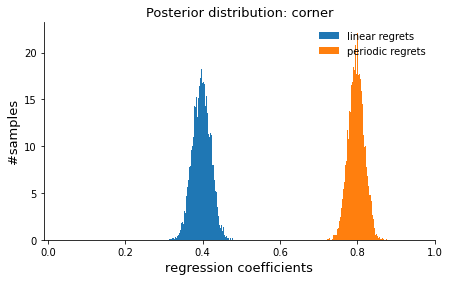

In [124]:
import seaborn as sns
import matplotlib.pylab as plt


error = 'corner'
lin = pm.trace_to_dataframe(trace_[error])['w_lin__0'].values
per = pm.trace_to_dataframe(trace_[error])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True,  bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
#plt.vlines(x=0., ymin=0, ymax=25, color='k')
plt.xlim([-0.01, 1.])
plt.title(f'Posterior distribution: {error}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

In [131]:
error = 'optimal'
regrets, probabilities = return_regrets_probabilities(data, 'compositional', error)
model_matrix = dict(y=probabilities[error].values,
                   x_lin=regrets['regrets_lin'],
                   x_per=regrets['regrets_per'])

model_[error], trace_[error] = run_logistic_regression(model_matrix)

Initializing SMC sampler...
Sampling 64 chains in 64 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.043
Stage:   4 Beta: 0.143
Stage:   5 Beta: 0.477
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.044
Stage:   4 Beta: 0.150
Stage:   5 Beta: 0.513
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.044
Stage:   4 Beta: 0.145
Stage:   5 Beta: 0.498
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.043
Stage:   4 Beta: 0.142
Stage:   5 Beta: 0.491
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.044
Stage:   4 Beta: 0.146
Stage:   5 Beta: 0.499
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.047
Stage:   4 Beta: 0.161
Stage:   5 Beta: 0.554

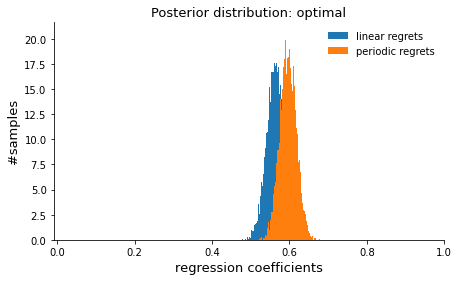

In [133]:
import seaborn as sns
import matplotlib.pylab as plt

error = 'optimal'
lin = pm.trace_to_dataframe(trace_[error])['w_lin__0'].values
per = pm.trace_to_dataframe(trace_[error])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True,  bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
#plt.vlines(x=0., ymin=0, ymax=175, color='k')
plt.xlim([-0.01, 1.])
plt.title(f'Posterior distribution: {error}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

In [110]:
error = 'neither'
model_matrix = dict(y=neither_corner_non_optimal,
                   x_lin=regrets['regrets_lin'],
                   x_per=regrets['regrets_per'])

model_[error], trace_[error] = run_logistic_regression(model_matrix)

Initializing SMC sampler...
Sampling 64 chains in 64 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.011
Stage:   3 Beta: 0.038
Stage:   4 Beta: 0.126
Stage:   5 Beta: 0.420
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.039
Stage:   4 Beta: 0.131
Stage:   5 Beta: 0.448
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.039
Stage:   4 Beta: 0.132
Stage:   5 Beta: 0.449
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.011
Stage:   3 Beta: 0.039
Stage:   4 Beta: 0.130
Stage:   5 Beta: 0.450
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.011
Stage:   3 Beta: 0.037
Stage:   4 Beta: 0.122
Stage:   5 Beta: 0.415
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.043
Stage:   4 Beta: 0.146
Stage:   5 Beta: 0.502

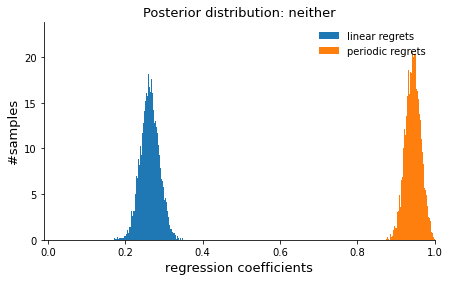

In [125]:
import seaborn as sns
import matplotlib.pylab as plt

error = 'neither'
lin = pm.trace_to_dataframe(trace_[error])['w_lin__0'].values
per = pm.trace_to_dataframe(trace_[error])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True,  bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
#plt.vlines(x=0., ymin=0, ymax=175, color='k')
plt.xlim([-0.01, 1.])
plt.title(f'Posterior distribution: {error}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

### first trial

In [15]:
for condition in ['corner', 'optimal', 'neither']:
#condition = 'neither'
    model_matrix = dict(y=y_class[condition],
                       x_lin=lin_regrets,
                       x_per=per_regrets)

    model[condition], traces[condition] = run_logistic_regression(model_matrix)

Initializing SMC sampler...
Sampling 64 chains in 64 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.002
Stage:   6 Beta: 0.008
Stage:   7 Beta: 0.026
Stage:   8 Beta: 0.103
Stage:   9 Beta: 0.325
Stage:  10 Beta: 0.979
Stage:  11 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.004
Stage:   6 Beta: 0.013
Stage:   7 Beta: 0.044
Stage:   8 Beta: 0.158
Stage:   9 Beta: 0.504
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.002
Stage:   6 Beta: 0.007
Stage:   7 Beta: 0.026
Stage:   8 Beta: 0.094
Stage:   9 Beta: 0.325
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.004
Stage:   6 Beta: 0.014

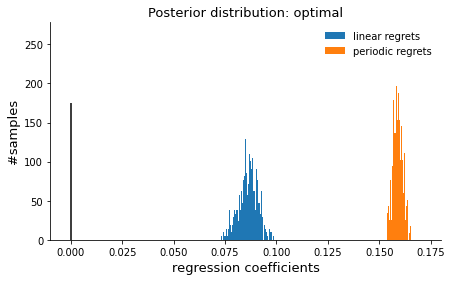

In [20]:
import seaborn as sns
import matplotlib.pylab as plt


condition = 'optimal'
lin = pm.trace_to_dataframe(traces[condition])['w_lin__0'].values
per = pm.trace_to_dataframe(traces[condition])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True,  bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
plt.vlines(x=0., ymin=0, ymax=175, color='k')
plt.xlim([-0.01, .18])
plt.title(f'Posterior distribution: {condition}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

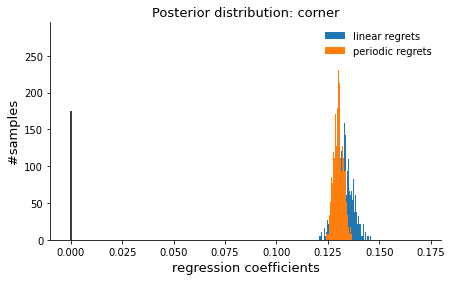

In [21]:
import seaborn as sns
import matplotlib.pylab as plt


condition = 'corner'
lin = pm.trace_to_dataframe(traces[condition])['w_lin__0'].values
per = pm.trace_to_dataframe(traces[condition])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True, bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
plt.vlines(x=0., ymin=0, ymax=175, color='k')
plt.xlim([-0.01, .18])
plt.title(f'Posterior distribution: {condition}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

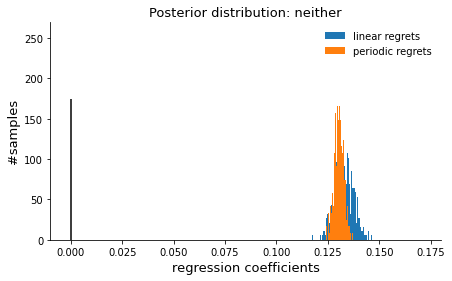

In [22]:
import seaborn as sns
import matplotlib.pylab as plt


condition = 'neither'
lin = pm.trace_to_dataframe(traces[condition])['w_lin__0'].values
per = pm.trace_to_dataframe(traces[condition])['w_per__0'].values
FONTSIZE = 13
f, ax = plt.subplots(1, 1, figsize=(7, 4))#, dpi=100)
#ax.hist(pm.trace_to_dataframe(traces[condition]), density=True, bins=1000, label=['linear regrets', 'periodic regrets'])
ax.hist(lin, density=True, bins=1000, label=['linear regrets'])
ax.hist(per, density=True, bins=1000, label=['periodic regrets'])
plt.vlines(x=0., ymin=0, ymax=175, color='k')
plt.xlim([-0.01, .18])
plt.title(f'Posterior distribution: {condition}', fontsize=FONTSIZE) 
plt.xlabel('regression coefficients', fontsize=FONTSIZE) 
plt.ylabel('#samples', fontsize=FONTSIZE) 
plt.legend(frameon=False, loc='upper right')
sns.despine()
plt.show()
#f.savefig('/notebooks/figs/PLOS/ErrorAnalysis_{}.svg'.format(rule), bbox_inches = 'tight')
plt.show()

### sklearn

In [104]:
X = np.stack((lin_regrets, per_regrets)).T
y = corner_classes

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)#, penalty='l1')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [127]:
from numpy import mean
from numpy import std
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.559 (0.006)


In [128]:
model.fit(X, y)

LogisticRegression(multi_class='multinomial')

In [129]:
model.coef_

array([[-0.02143006, -0.02894256],
       [-0.02015541,  0.02114529],
       [ 0.04158547,  0.00779727]])

#### statsmodels

In [79]:
from statsmodels.discrete.discrete_model import MNLogit as mnlogit

In [100]:
corner_non_optimal = (optimal==0)*corner
corner_non_optimal[corner_non_optimal==1]=2
corner_classes = optimal+corner_non_optimal
corner_classes[corner_classes==0] = 3

In [101]:
X = np.stack((lin_regrets, per_regrets)).T
y = corner_classes

In [102]:
mnlogit_model = mnlogit(y, X)
mnlogit_model = mnlogit_model.fit()
print("Parameters: ", mnlogit_model.params)
print("Marginal effects: ")
print(mnlogit_model.summary())

Optimization terminated successfully.
         Current function value: 1.032819
         Iterations 5
Parameters:  [[-0.09376696 -0.04290051]
 [-0.01091176 -0.03657652]]
Marginal effects: 
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1840
Model:                        MNLogit   Df Residuals:                     1836
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                -0.03945
Time:                        20:57:36   Log-Likelihood:                -1900.4
converged:                       True   LL-Null:                       -1828.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0938

In [47]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [1]:
# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# summarize the dataset
print(X.shape, y.shape)
print(Counter(y))

(1000, 10) (1000,)
Counter({1: 334, 2: 334, 0: 332})


In [2]:
y

array([1, 0, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 0,
       2, 2, 0, 0, 2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1,
       1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2,
       0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2,
       1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1,
       0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 1, 2, 0, 0, 1,
       0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0,
       1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2,
       1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 0, 0, 2, 1, 1,

## rewards vs dls

In [2]:
import torch

rule = 'add'
trials = np.arange(10,15)
if rule == 'add':
    _, load_rewards = torch.load('/notebooks/notebooks/temp/additive_curriculum.pth')  
else:
    _, load_rewards, _ = torch.load('/notebooks/notebooks/temp/changepoint_curriculum.pth')
rewards = load_rewards[:, :, trials].sum(2).sum(1) # torch.stack(load_rewards)[1].sum(2).sum(1) if rule == 'add' else 

dls = torch.load('/notebooks/modelfits/rl3_stickiness/dls_{}.pth'.format(rule))
dls[np.where(rewards==rewards.min())[0][0]] = np.NaN
rewards[np.where(rewards==rewards.min())[0][0]] = np.NaN

In [73]:
rl3 = pd.DataFrame.from_dict( {'rewards': rewards, 'dls': dls})

md = smf.ols("rewards ~ dls", data=rl3)
mdf = md.fit()
print(mdf.summary())

In [75]:
np.sqrt(mdf.rsquared), np.sqrt(mdf.rsquared_adj)

(0.3211821321362019, 0.30509192905112364)

## archive